# GAN Project
## Liz Parker, Colin Craighead, and Aren Dalloul

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import utils
import tensorflow.keras.preprocessing.image as img
import scipy.io
from PIL import Image

In [2]:
test_mat = scipy.io.loadmat("data/test_data.mat")
train_mat = scipy.io.loadmat("data/train_data.mat")

In [3]:
def unpack_mat(mat, train_or_test):
    df = pd.DataFrame()
    paths = []
    breeds = []
    breed_ids = []
    num_datapoints = len(mat[train_or_test][0][0][0])
    for i in range(num_datapoints):
        path = "images/" + mat[train_or_test][0][0][0][i][0][0]
        paths.append(path)
        temp_arr = mat[train_or_test][0][0][1][i][0][0].strip().split('-')
        breed_str = "-".join(temp_arr[1:]).split('/')[0]
        breeds.append(breed_str)
        breed_ids.append(mat[train_or_test][0][0][2][i][0])
    df['breed'] = breeds
    df['breed_id'] = breed_ids
    df['path'] = paths
    return df

In [4]:
train_df = unpack_mat(train_mat, 'train_info')
test_df = unpack_mat(test_mat, 'test_info')
train_df.head()

# #TO REMOVE !!!!!!!!!!!!!
# train_df = train_df.truncate(after = 1000)
train_df = train_df.sample(frac=.25)

In [5]:
train_df

,breed,breed_id,path
2255,Ibizan_hound,23,images/n02091244-Ibizan_hound/n02091244_5180.jpg
5998,German_short-haired_pointer,60,images/n02100236-German_short-haired_pointer/n...
4578,miniature_schnauzer,46,images/n02097047-miniature_schnauzer/n02097047...
1519,Walker_hound,16,images/n02089867-Walker_hound/n02089867_2142.jpg
3256,Kerry_blue_terrier,33,images/n02093859-Kerry_blue_terrier/n02093859_...
...,...,...,...
10505,Great_Pyrenees,106,images/n02111500-Great_Pyrenees/n02111500_260.jpg
7119,kuvasz,72,images/n02104029-kuvasz/n02104029_133.jpg
5863,Chesapeake_Bay_retriever,59,images/n02099849-Chesapeake_Bay_retriever/n020...
2751,Weimaraner,28,images/n02092339-Weimaraner/n02092339_93.jpg


In [6]:
X_train = np.array([img.img_to_array(img.load_img(path, target_size = (256,256))) for path in train_df['path']])

In [7]:
X_train.shape

(3000, 256, 256, 3)

In [8]:
X_train = X_train[:,:,:]/255

In [9]:
X_train.shape

(3000, 256, 256, 3)

In [10]:
# define the standalone discriminator model
def define_discriminator(in_shape=(256,256,3)):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(2, activation='sigmoid'))
    # compile model
    opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# define model
model_d = define_discriminator()
# summarize the model
model_d.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 262144)            0

In [11]:
def create_random_image(dim,num_samples):
    return np.random.randn(dim[0]*dim[1]*dim[2]*num_samples).reshape(num_samples,dim[0],dim[1],dim[2])

In [12]:
num_fakes = 4000
X_fakes = create_random_image([256,256,3],num_fakes)

In [13]:
X_fakes.shape

(4000, 256, 256, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


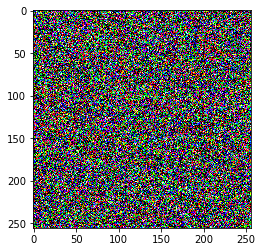

In [14]:
plt.imshow(X_fakes[0])

In [15]:
y_fakes = np.tile([1.0,0.0],(num_fakes,1))
y_fakes.shape

(4000, 2)

In [16]:
y_train = np.tile([0.0,1.0],(X_train.shape[0],1))
y_train.shape

(3000, 2)

In [17]:
mix_y_train = np.append(y_train,y_fakes,axis=0)
mix_y_train.shape

(7000, 2)

In [18]:
mix_X_train = np.append(X_train,X_fakes,axis=0)
mix_X_train.shape

(7000, 256, 256, 3)

In [19]:
model_d.fit(mix_X_train,mix_y_train,epochs=1,shuffle=True,verbose=1)

Train on 7000 samples
7000/7000 [==============================] - 148s 21ms/sample - loss: 0.0064 - accuracy: 0.9959


In [20]:
latent_dim = 100

def define_generator(latent_dim):
    model = tf.keras.models.Sequential()
    # foundation for 8x8 image
    n_nodes = 128 * 8 * 8
    model.add(tf.keras.layers.Dense(n_nodes, input_dim=latent_dim))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Reshape((8, 8, 128)))
    # upsample to 16x16
    model.add(tf.keras.layers.UpSampling2D())
    model.add(layers.Conv2D(128,(4,4),padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(tf.keras.layers.UpSampling2D())
    model.add(layers.Conv2D(64,(4,4),padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    # upsample to 64x64
    model.add(tf.keras.layers.UpSampling2D())
    model.add(layers.Conv2D(64,(4,4),padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    # upsample to 128x128
    model.add(tf.keras.layers.UpSampling2D())
    model.add(layers.Conv2D(32,(4,4),padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    # upsample to 256x256
    model.add(tf.keras.layers.Conv2DTranspose(32, (4,4), strides=(2,2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Conv2D(3, (5,5), activation='sigmoid', padding='same'))
    return model
    
model_g = define_generator(latent_dim)
model_g.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8192)              827392    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8192)              0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 128)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 128)      

In [21]:
def generate_normal_noise_points(latent_dim, n_samples):
    points = np.random.randn(latent_dim * n_samples)
    return points.reshape(n_samples, latent_dim)

In [22]:
def generate_fake_images(model, latent_dim, n_samples):
    x_input = generate_normal_noise_points(latent_dim, n_samples)
    fake_images = model.predict(x_input)
    labels = np.tile([1.0,0.0],(n_samples,1))
    return fake_images, labels

In [23]:
test_image,_ =  generate_fake_images(model_g,latent_dim,1)
test_image.shape

(1, 256, 256, 3)

In [24]:
# test_image = test_image[:,:,:]*255

In [25]:
test_image

array([[[[0.5005006 , 0.5002655 , 0.5003078 ],
         [0.49924833, 0.49898508, 0.5006827 ],
         [0.50054586, 0.50010324, 0.50028807],
         ...,
         [0.49922538, 0.5009601 , 0.5009414 ],
         [0.50096697, 0.49981815, 0.5007633 ],
         [0.49881864, 0.5009857 , 0.50093246]],

        [[0.50034505, 0.50031376, 0.50143903],
         [0.5014294 , 0.499452  , 0.5023625 ],
         [0.49962384, 0.502732  , 0.5022635 ],
         ...,
         [0.5000595 , 0.49964893, 0.5010865 ],
         [0.500615  , 0.5004729 , 0.49901435],
         [0.50022477, 0.500101  , 0.50061536]],

        [[0.49889523, 0.5007371 , 0.4994884 ],
         [0.49777684, 0.49926472, 0.50185686],
         [0.49888667, 0.50132555, 0.5000404 ],
         ...,
         [0.49843943, 0.49964145, 0.500719  ],
         [0.5013891 , 0.49994314, 0.5009481 ],
         [0.49814224, 0.5008381 , 0.5004934 ]],

        ...,

        [[0.5000322 , 0.500036  , 0.50000197],
         [0.50105226, 0.49994105, 0.5001541 ]

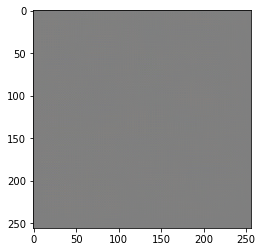

In [26]:
plt.imshow(test_image[0])

In [27]:
def define_gan(g_model, d_model):
    d_model.trainable = False
    model = tf.keras.models.Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [28]:
gan_model = define_gan(model_g, model_d)
gan_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 256, 256, 3)       1339171   
_________________________________________________________________
sequential (Sequential)      (None, 2)                 543682    
Total params: 1,882,853
Trainable params: 1,338,595
Non-trainable params: 544,258
_________________________________________________________________


In [29]:
def train(g_model, d_model, gan_model, real_images, latent_dim, n_epochs=3, n_batch=32):
    bat_per_epo = real_images.shape[0]//n_batch
    half_batch = n_batch//2
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            X_real = real_images[np.random.randint(0,real_images.shape[0],half_batch)]
            y_real = np.tile([0.0,1.0],(half_batch,1))
            X_fake, y_fake = generate_fake_images(g_model, latent_dim, half_batch)
            # X, y = np.append(X_real,X_fake,axis=0), np.append(y_real,y_fake,axis=0)
            d_loss, _ = d_model.train_on_batch(X_real, y_real)
            d_loss, _ = d_model.train_on_batch(X_fake, y_fake)
            
            X_gan = generate_normal_noise_points(latent_dim, n_batch)
            y_gan = np.tile([0.0,1.0],(n_batch,1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
    return g_model, d_model, gan_model

In [30]:
final_g_model, final_d_model, final_gan_model = train(model_g, model_d, gan_model, X_train, latent_dim)

>1, 1/93, d=14.838, g=26.673
>1, 2/93, d=0.000, g=5.702
>1, 3/93, d=4.863, g=0.250
>1, 4/93, d=1.221, g=1.921
>1, 5/93, d=0.624, g=1.113
>1, 6/93, d=0.894, g=1.039
>1, 7/93, d=0.760, g=1.088
>1, 8/93, d=0.751, g=1.091
>1, 9/93, d=0.746, g=1.025
>1, 10/93, d=0.578, g=1.221
>1, 11/93, d=0.663, g=0.954
>1, 12/93, d=0.754, g=0.920
>1, 13/93, d=0.721, g=0.979
>1, 14/93, d=0.666, g=0.909
>1, 15/93, d=0.699, g=0.882
>1, 16/93, d=0.614, g=0.829
>1, 17/93, d=0.664, g=0.757
>1, 18/93, d=0.591, g=0.758
>1, 19/93, d=0.588, g=0.661
>1, 20/93, d=0.676, g=0.550
>1, 21/93, d=0.738, g=0.528
>1, 22/93, d=0.552, g=0.520
>1, 23/93, d=0.549, g=0.436
>1, 24/93, d=0.583, g=0.371
>1, 25/93, d=0.584, g=0.300
>1, 26/93, d=0.586, g=0.273
>1, 27/93, d=0.514, g=0.295
>1, 28/93, d=0.480, g=0.228
>1, 29/93, d=0.525, g=0.174
>1, 30/93, d=0.506, g=0.134
>1, 31/93, d=0.577, g=0.105
>1, 32/93, d=0.596, g=0.094
>1, 33/93, d=0.465, g=0.085
>1, 34/93, d=0.547, g=0.060
>1, 35/93, d=0.463, g=0.060
>1, 36/93, d=0.360, g=0.050

In [31]:
test_image2,_ =  generate_fake_images(final_g_model,latent_dim,1)

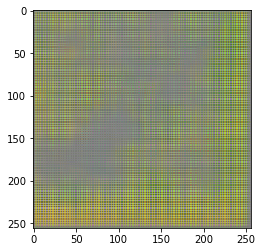

In [32]:
plt.imshow(test_image2[0])

In [33]:
test_image3and,_ =  generate_fake_images(final_g_model,latent_dim,5)

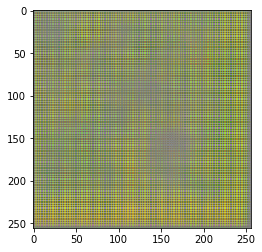

In [34]:
plt.imshow(test_image3and[0])

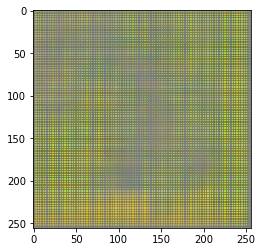

In [35]:
plt.imshow(test_image3and[1])

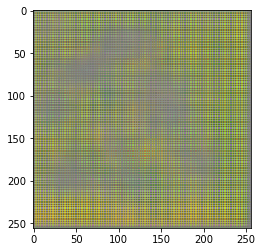

In [36]:
plt.imshow(test_image3and[2])

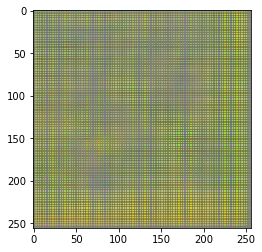

In [37]:
plt.imshow(test_image3and[3])

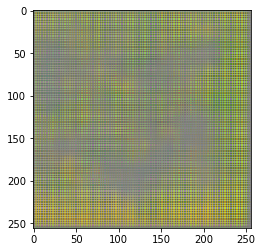

In [38]:
plt.imshow(test_image3and[4])